# 4️⃣ Inference Benchmark & Analysis (OpenCV DNN, FP32 + Pruned)


In [1]:
# 1. Mount Google Drive and set root path
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/hardware_aware_optimization'

Mounted at /content/drive


In [2]:
!pip install opencv-python

In [3]:
import cv2 as cv
import numpy as np
import time
import torch
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
import matplotlib.pyplot as plt


test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
testset = torchvision.datasets.CIFAR10(root=f'{root}/data/cifar10', train=False, download=True)
images = np.stack([test_transform(testset[i][0]).numpy() for i in range(1000)])
labels = np.array([testset[i][1] for i in range(1000)])

def benchmark_onnx(onnx_path, images):
    net = cv.dnn.readNetFromONNX(onnx_path)
    times = []
    correct = 0
    for i in range(images.shape[0]):
        inp = images[i][np.newaxis, :]
        net.setInput(inp)
        start = time.time()
        out = net.forward()
        end = time.time()
        pred = np.argmax(out)
        if pred == labels[i]:
            correct += 1
        times.append((end-start)*1000)
    acc = 100 * correct / images.shape[0]
    latency = np.mean(times)
    return acc, latency


In [4]:
# Benchmark FP32
fp32_onnx_path = f'{root}/models/model.onnx'
acc_fp32, lat_fp32 = benchmark_onnx(fp32_onnx_path, images)
size_fp32 = os.path.getsize(fp32_onnx_path) / 1024 / 1024
print(f"FP32 (OpenCV DNN): Acc={acc_fp32:.2f}%, Latency={lat_fp32:.2f}ms, Size={size_fp32:.2f}MB")

# Benchmark Pruned FP32
pruned_onnx_path = f'{root}/models/model_pruned.onnx'
if os.path.isfile(pruned_onnx_path):
    acc_pruned, lat_pruned = benchmark_onnx(pruned_onnx_path, images)
    size_pruned = os.path.getsize(pruned_onnx_path) / 1024 / 1024
    print(f"Pruned FP32 (OpenCV DNN): Acc={acc_pruned:.2f}%, Latency={lat_pruned:.2f}ms, Size={size_pruned:.2f}MB")
else:
    acc_pruned, lat_pruned, size_pruned = None, None, None

FP32 (OpenCV DNN): Acc=81.60%, Latency=3.29ms, Size=8.37MB
Pruned FP32 (OpenCV DNN): Acc=81.80%, Latency=3.10ms, Size=8.37MB


In [5]:
# Save Results
results = pd.DataFrame([
    {"Model": "FP32", "Accuracy": acc_fp32, "Latency_ms": lat_fp32, "Size_MB": size_fp32},
    {"Model": "Pruned FP32", "Accuracy": acc_pruned, "Latency_ms": lat_pruned, "Size_MB": size_pruned},
])
results.to_csv(f'{root}/results/size_chart.csv', index=False)
print(results)

         Model  Accuracy  Latency_ms   Size_MB
0         FP32      81.6    3.293362  8.369335
1  Pruned FP32      81.8    3.098687  8.369335


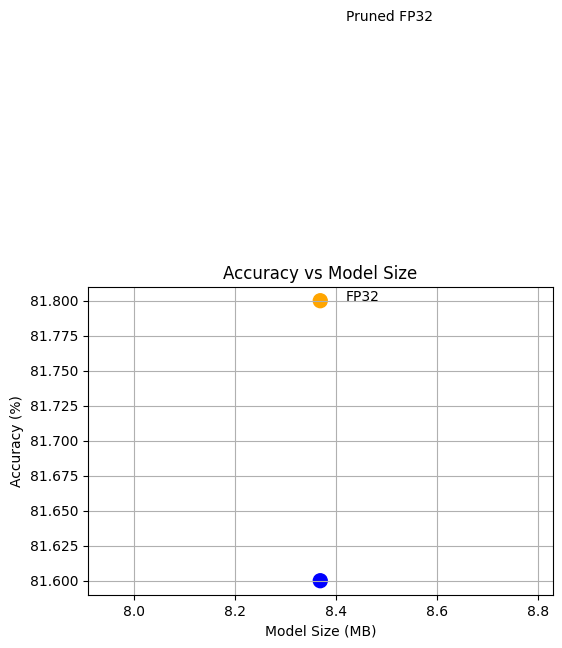

In [6]:
# Plot Accuracy vs Size
plt.figure(figsize=(6,4))
plt.scatter(results["Size_MB"], results["Accuracy"], c=['blue', 'orange'], s=100)
for i, row in results.iterrows():
    plt.text(row["Size_MB"]+0.05, row["Accuracy"]+0.2, row["Model"])
plt.xlabel("Model Size (MB)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Model Size")
plt.grid(True)
plt.savefig(f'{root}/results/accuracy_plot.png')
plt.show()

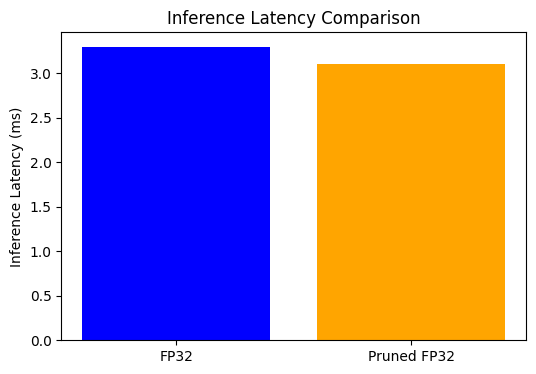

In [7]:
# Plot Inference Latency
plt.figure(figsize=(6,4))
plt.bar(results["Model"], results["Latency_ms"], color=['blue', 'orange'])
plt.ylabel("Inference Latency (ms)")
plt.title("Inference Latency Comparison")
plt.savefig(f'{root}/results/latency_comparison.png')
plt.show()